In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 
import pandas as pd


/data/phillip_guo/miniconda3/envs/cb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

n_layers = 42
n_heads = 16

print(torch.cuda.memory_allocated() / 1024**3)

0.0


## Load Data

In [3]:
# localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
# run_ids = [2]

# # inject_sport = "golf"
# inject_sport = None
# # forget_sport = "basketball"
# forget_sport = None
# # forget_athletes = None
# forget_athletes = 16

# last_epoch = 49

# for run_id in run_ids:
#     for localization_type in localization_types:
#         if forget_sport is not None:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
#         else:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

#         if run_id is not None:
#             save_dir = f"{save_dir}_{run_id}"

#         print(save_dir)
#         with open(f"{save_dir}/models/gemma_{localization_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", 'rb') as f:
#             train_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/probes_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}.pkl", 'rb') as f:
#             probe_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", 'rb') as f:
#             relearning_metrics = pickle.load(f)
#         with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
#             mmlu_metrics = pickle.load(f)

#         test_loses = {task: train_metrics["test_losses"][task][-1] for task in train_metrics["test_losses"].keys()}
#         # print(test_loses) # keys: task_name, values: value
#         # print(train_metrics["adversarial_evals"][last_epoch]) # key: 'Normal' or 'MC', with sub-dictionaries as values with keys: 'forget', 'maintain'

#         # # key: one for every layer (28 layers)
#         # print(probe_metrics['all_forget_accs'][localization_type])
#         # print(probe_metrics['all_maintain_accs'][localization_type])

#         # print(relearning_metrics['relearning_test_results'][localization_type]) # list of len 10 that contains test results at every step, each test result is a dictionary

#         # print(mmlu_metrics["results"]['mmlu']['acc,none']) # just an int
#         # print()

In [4]:
import pickle
import pandas as pd

localization_types = ["manual_interp", "new_forget_ct", "forget_ap", "all_mlps", "nonlocalized", "random"]
run_ids = [11, 12, 13]

inject_fact = True
forget_facts = 16
n_relearn_facts = 16
n_relearn_iters = 20
last_epoch = 49

# Initialize lists to hold the data
test_losses_list = []
adversarial_evals_list = []
forget_accs_list = []
maintain_accs_list = []
relearning_results_list = []
mmlu_acc_list = []

for run_id in run_ids:
    for localization_type in localization_types:
        # if forget_sport is not None:
        #     if inject_sport is not None:
        #         save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
        #     else:
        #         save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
        # else:
        #     if inject_sport is not None:
        #         save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
        #     else:
        #         save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

        if inject_fact:
            save_dir = f"results/{model_name_or_path}_localized_finetuning_injection_counterfact/{localization_type}"
        else:
            save_dir = f"results/{model_name_or_path}_localized_finetuning_counterfact/{localization_type}"
        if run_id is not None:
            save_dir = f"{save_dir}_{run_id}"

        with open(f"{save_dir}/models/{model_type}_{localization_type}_combine_heads=True_unlearn_{forget_facts=}_{inject_fact=}_metrics.pkl", 'rb') as f:
            train_metrics = pickle.load(f)
        # with open(f"{save_dir}/results/probes_{model_type}_combine_heads=True_beta=3_unlearn_{forget_facts=}_{inject_fact=}.pkl", 'rb') as f:
        #     probe_metrics = pickle.load(f)
        with open(f"{save_dir}/results/relearning_n_relearn_facts={n_relearn_facts}_n_relearn_iters={n_relearn_iters}_{model_type}_combine_heads=True_beta=3_unlearn_{forget_facts=}_results.pkl", 'rb') as f:
            relearning_metrics = pickle.load(f)
        with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
            mmlu_metrics = pickle.load(f)

        # Collect test losses
        for task, value in train_metrics["test_losses"].items():
            test_losses_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'task_name': task,
                'test_loss': value[-1]
            })

        # Collect adversarial evaluations
        for eval_type, results in train_metrics["adversarial_evals"][last_epoch].items():
            adversarial_evals_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'eval_type': eval_type,
                'forget': results['forget'],
                'maintain': results['maintain']
            })

        # Collect forget accuracy
        # for layer, acc in probe_metrics['all_forget_accs'][localization_type].items():
        #     forget_accs_list.append({
        #         'localization_type': localization_type,
        #         'run_id': run_id,
        #         'layer': layer,
        #         'forget_acc': acc
        #     })

        # Collect maintain accuracy
        # for layer, acc in probe_metrics['all_maintain_accs'][localization_type].items():
        #     maintain_accs_list.append({
        #         'localization_type': localization_type,
        #         'run_id': run_id,
        #         'layer': layer,
        #         'maintain_acc': acc
        #     })

        # Collect relearning test results
        for step, results in enumerate(relearning_metrics['relearning_test_results'][localization_type]):
            relearning_results_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'step': step,
                'mmlu': results['MMLU'],
                'forget': results['adversarial']['Normal']['forget'],
                'maintain': results['adversarial']['Normal']['maintain'],
                'mc_forget': results['adversarial']['MC']['forget'],
                'mc_maintain': results['adversarial']['MC']['maintain'],
            })

        # Collect MMLU accuracy
        mmlu_acc_list.append({
            'localization_type': localization_type,
            'run_id': run_id,
            'mmlu_acc': mmlu_metrics["results"]['mmlu']['acc,none']
        })

# Convert lists to DataFrames
test_losses_df = pd.DataFrame(test_losses_list)
adversarial_evals_df = pd.DataFrame(adversarial_evals_list)
# probe_forget_accs_df = pd.DataFrame(forget_accs_list)
# probe_maintain_accs_df = pd.DataFrame(maintain_accs_list)
relearning_results_df = pd.DataFrame(relearning_results_list)
mmlu_acc_df = pd.DataFrame(mmlu_acc_list)

# Display the dataframes to the user
display(test_losses_df)
display(adversarial_evals_df)
# display(probe_forget_accs_df)
# display(probe_maintain_accs_df)
display(relearning_results_df)
display(mmlu_acc_df)

,localization_type,run_id,task_name,test_loss
0,manual_interp,11,pile,2.328797
1,manual_interp,11,pile_accuracy,0.542328
2,manual_interp,11,forget_fact,15.628295
3,manual_interp,11,forget_fact_accuracy,0.000008
4,manual_interp,11,maintain_fact,0.102996
...,...,...,...,...
139,random,13,forget_fact_accuracy,0.000038
140,random,13,maintain_fact,0.143456
141,random,13,maintain_fact_accuracy,0.984471
142,random,13,inject_fact,0.000301


,localization_type,run_id,eval_type,forget,maintain
0,manual_interp,11,Normal,0.000008,0.966674
1,manual_interp,11,MC,0.269566,0.921063
2,manual_interp,11,Paraphrase,0.051705,0.620306
3,manual_interp,11,Neighborhood,0.730772,0.600305
4,new_forget_ct,11,Normal,0.000028,0.972769
...,...,...,...,...,...
67,nonlocalized,13,Neighborhood,0.733323,0.686449
68,random,13,Normal,0.000038,0.974830
69,random,13,MC,0.668814,0.947645
70,random,13,Paraphrase,0.113779,0.738144


,localization_type,run_id,step,mmlu,forget,maintain,mc_forget,mc_maintain
0,manual_interp,11,0,0.75,0.001489,0.961772,0.144664,0.880222
1,manual_interp,11,1,0.75,0.068363,0.939521,0.155504,0.909254
2,manual_interp,11,2,0.76,0.165706,0.942647,0.119800,0.881951
3,manual_interp,11,3,0.76,0.311663,0.884407,0.145354,0.876415
4,manual_interp,11,4,0.75,0.442575,0.833393,0.185331,0.862605
...,...,...,...,...,...,...,...,...
355,random,13,15,0.73,0.878778,0.890056,0.752794,0.892679
356,random,13,16,0.73,0.883433,0.903248,0.738073,0.925392
357,random,13,17,0.73,0.885331,0.905443,0.703736,0.927450
358,random,13,18,0.73,0.886406,0.901376,0.771884,0.887412


,localization_type,run_id,mmlu_acc
0,manual_interp,11,0.692138
1,new_forget_ct,11,0.691639
2,forget_ap,11,0.690144
3,all_mlps,11,0.688150
4,nonlocalized,11,0.683022
5,random,11,0.691141
6,manual_interp,12,0.691782
7,new_forget_ct,12,0.691711
8,forget_ap,12,0.691497
9,all_mlps,12,0.687010


## Make Graphs

### General Performance (tables)

In [5]:
from scipy.stats import sem

# Perform the groupby operations
forget_fact_accuracy = test_losses_df.query("task_name == 'forget_fact_accuracy'").groupby("localization_type")['test_loss'].mean()
maintain_fact_accuracy = test_losses_df.query("task_name == 'maintain_fact_accuracy'").groupby("localization_type")['test_loss'].mean()
mmlu_acc_mean = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].mean()
# mmlu_acc_sem = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].apply(sem) * (mmlu_acc_df.groupby("localization_type")["mmlu_acc"].count() - 1)
mc_forget_mean = adversarial_evals_df.query("eval_type == 'MC'").groupby("localization_type")['forget'].mean()
paraphrase_forget_mean = adversarial_evals_df.query("eval_type == 'Paraphrase'").groupby("localization_type")['forget'].mean()
neighborhood_forget_mean = adversarial_evals_df.query("eval_type == 'Neighborhood'").groupby("localization_type")['forget'].mean()

# Concatenate the results into one DataFrame
combined_df = pd.concat([forget_fact_accuracy, maintain_fact_accuracy, mmlu_acc_mean, mc_forget_mean, paraphrase_forget_mean, neighborhood_forget_mean], axis=1)
combined_df.columns = ['forget_fact_accuracy', 'maintain_fact_accuracy', 'mmlu_acc_mean', 'mc_forget_mean', 'paraphrase_forget_mean', 'neighborhood_forget_mean']

print(f"For {forget_facts=}, {inject_fact=}")
# Display the combined DataFrame
display(combined_df)

For forget_facts=16, inject_fact=True


,forget_fact_accuracy,maintain_fact_accuracy,mmlu_acc_mean,mc_forget_mean,paraphrase_forget_mean,neighborhood_forget_mean
localization_type,,,,,,
all_mlps,0.000120,0.926628,0.687628,0.389935,0.083319,0.724873
forget_ap,0.000117,0.974189,0.690903,0.943678,0.286443,0.681255
manual_interp,0.000030,0.965057,0.691378,0.294677,0.034569,0.733265
new_forget_ct,0.000024,0.973046,0.691734,0.481209,0.031631,0.736296
nonlocalized,0.000107,0.920397,0.681788,0.411491,0.103592,0.745817
random,0.000052,0.979288,0.690073,0.650512,0.159196,0.757015


### Plot Relearning

In [6]:
relearning_results_df.query("localization_type == 'manual_interp'")

,localization_type,run_id,step,mmlu,forget,maintain,mc_forget,mc_maintain
0,manual_interp,11,0,0.75,0.001489,0.961772,0.144664,0.880222
1,manual_interp,11,1,0.75,0.068363,0.939521,0.155504,0.909254
2,manual_interp,11,2,0.76,0.165706,0.942647,0.119800,0.881951
3,manual_interp,11,3,0.76,0.311663,0.884407,0.145354,0.876415
4,manual_interp,11,4,0.75,0.442575,0.833393,0.185331,0.862605
5,manual_interp,11,5,0.76,0.548657,0.797127,0.182801,0.852077
6,manual_interp,11,6,0.76,0.621947,0.796491,0.216270,0.860340
7,manual_interp,11,7,0.76,0.661083,0.805646,0.190546,0.844337
8,manual_interp,11,8,0.75,0.691684,0.801580,0.156712,0.817008
9,manual_interp,11,9,0.75,0.709032,0.829215,0.214294,0.832695


In [7]:
adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain'])

forget                                    \
eval_type                       MC Neighborhood    Normal Paraphrase   
localization_type run_id                                               
all_mlps          11      0.415477     0.746903  0.000336   0.096988   
                  12      0.328457     0.685782  0.000016   0.073870   
                  13      0.425871     0.741934  0.000008   0.079098   
forget_ap         11      0.955216     0.694657  0.000096   0.276973   
                  12      0.939038     0.657094  0.000087   0.278378   
                  13      0.936780     0.692013  0.000168   0.303978   
manual_interp     11      0.269566     0.730772  0.000008   0.051705   
                  12      0.321684     0.726441  0.000025   0.019805   
                  13      0.292781     0.742582  0.000057   0.032198   
new_forget_ct     11      0.503309     0.739585  0.000028   0.011042   
                  12      0.437066     0.727425  0.000032   0.044621   
                  13      0.503252     0.741878  0.000011   0.039228   
nonlocalized      11      0.464176     0.752803  0.000072   0.189338   
                  12      0.416874     0.751327  0.000046   0.072694   
                  13      0.353422     0.733323  0.000202   0.048743   
random            11      0.672623     0.759670  0.000084   0.210881   
                  12      0.610098     0.762228  0.000035   0.152928   
                  13      0.668814     0.749147  0.000038   0.113779   

                          maintain                                    
eval_type                       MC Neighborhood    Normal Paraphrase  
localization_type run_id                                              
all_mlps          11      0.905267     0.720136  0.922170   0.778963  
                  12      0.801578     0.627348  0.928593   0.726806  
                  13      0.867211     0.694535  0.904707   0.785499  
forget_ap         11      0.954877     0.577371  0.964999   0.684159  
                  12      0.961403     0.571478  0.970965   0.739223  
                  13      0.964640     0.605359  0.971695   0.699900  
manual_interp     11      0.921063     0.600305  0.966674   0.620306  
                  12      0.942151     0.610369  0.959878   0.725168  
                  13      0.977553     0.695816  0.954149   0.668508  
new_forget_ct     11      0.972195     0.587994  0.972769   0.734349  
                  12      0.985981     0.641273  0.964350   0.719600  
                  13      0.963175     0.636427  0.966525   0.726295  
nonlocalized      11      0.856713     0.613190  0.914598   0.747750  
                  12      0.833741     0.644921  0.934481   0.774144  
                  13      0.843691     0.686449  0.917813   0.774671  
random            11      0.958911     0.685950  0.975128   0.769133  
                  12      0.957511     0.635995  0.977620   0.772540  
                  13      0.947645     0.675106  0.974830   0.738144

In [8]:
adversarial_evals_df

,localization_type,run_id,eval_type,forget,maintain
0,manual_interp,11,Normal,0.000008,0.966674
1,manual_interp,11,MC,0.269566,0.921063
2,manual_interp,11,Paraphrase,0.051705,0.620306
3,manual_interp,11,Neighborhood,0.730772,0.600305
4,new_forget_ct,11,Normal,0.000028,0.972769
...,...,...,...,...,...
67,nonlocalized,13,Neighborhood,0.733323,0.686449
68,random,13,Normal,0.000038,0.974830
69,random,13,MC,0.668814,0.947645
70,random,13,Paraphrase,0.113779,0.738144


/tmp/ipykernel_1846240/2312270900.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)


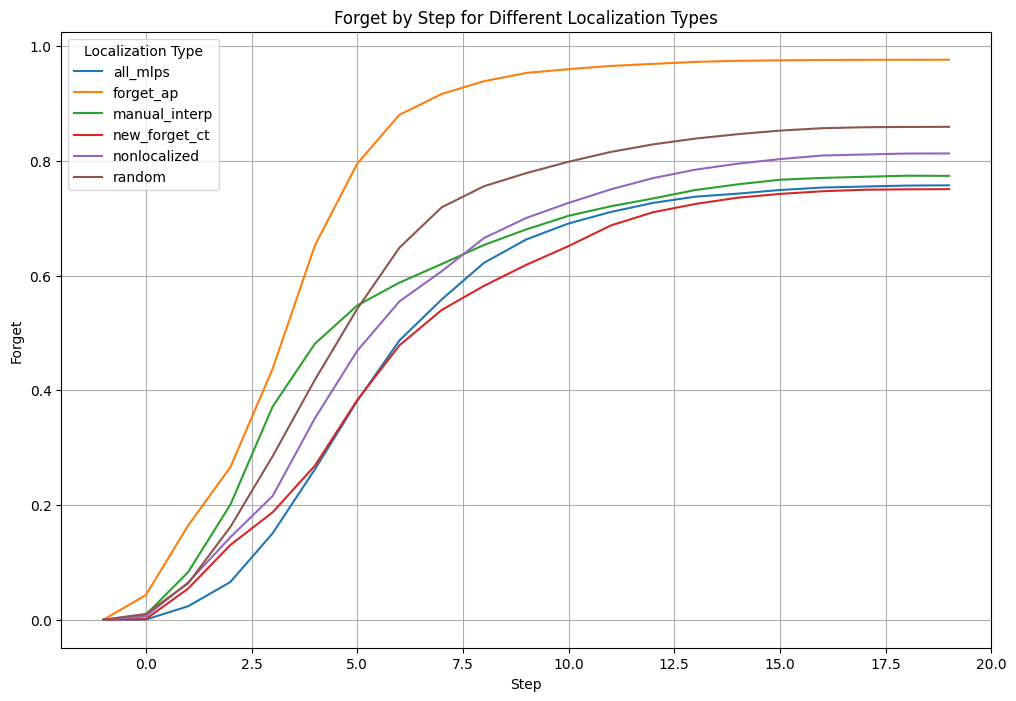

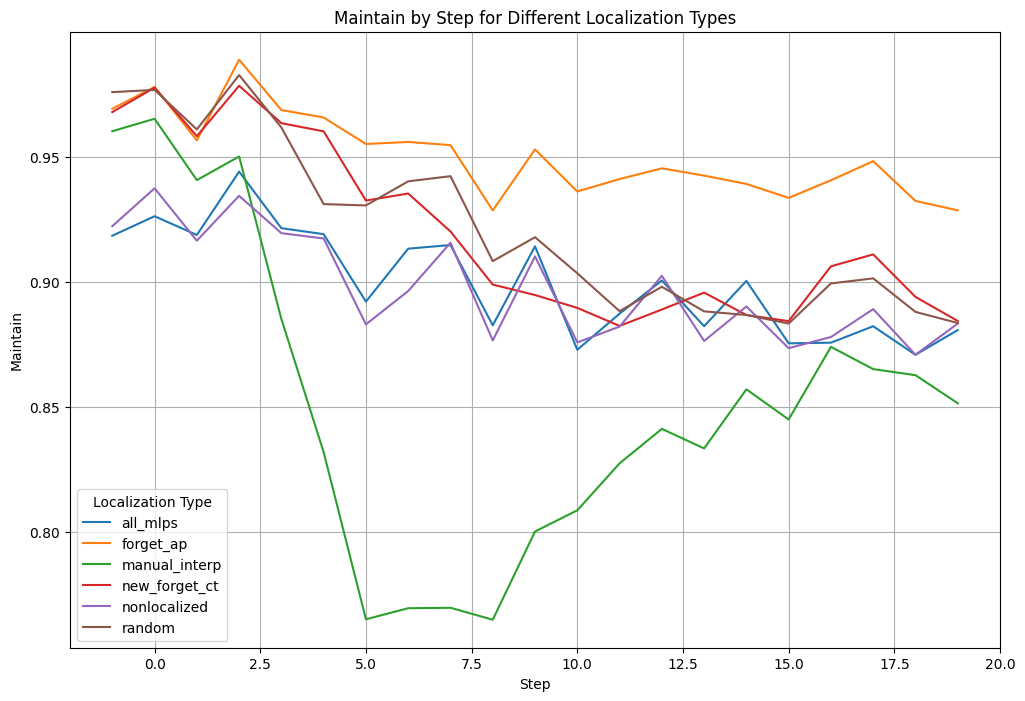

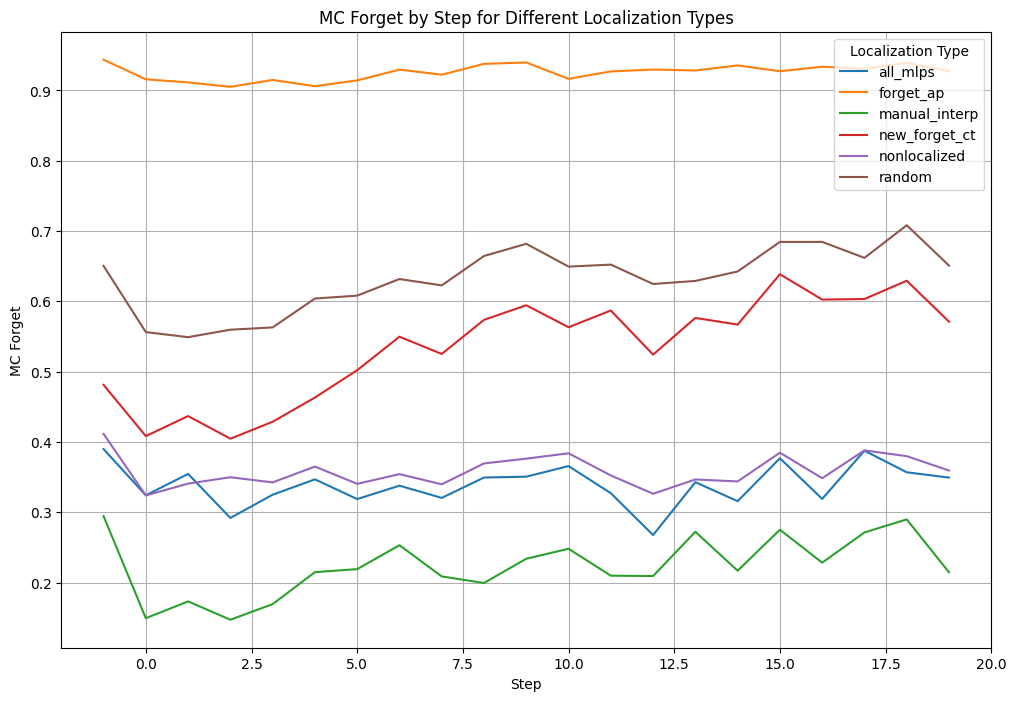

In [9]:
import pandas as pd

# Merge the adversarial_evals_df to get the required columns
merged_df = adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain']).reset_index()
merged_df.columns = ['localization_type', 'run_id', 'forget_MC', 'forget_Neighborhood', 'forget_Normal', 'forget_Paraphrase', 'maintain_MC', 'maintain_Neighborhood', 'maintain_Normal', 'maintain_Paraphrase']

# Create new rows with step = -1
new_rows = merged_df.copy()
new_rows['step'] = -1
new_rows['mmlu'] = None  # Leave mmlu blank
new_rows = new_rows.rename(columns={
    'forget_Normal': 'forget',
    'maintain_Normal': 'maintain',
    'forget_MC': 'mc_forget',
    'maintain_MC': 'mc_maintain'
})

# Select and reorder the columns to match relearning_results_df
new_rows = new_rows[['localization_type', 'run_id', 'step', 'mmlu', 'forget', 'maintain', 'mc_forget', 'mc_maintain']]

# Append the new rows to relearning_results_df
combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)

# Display the updated DataFrame
# display(combined_relearning_results_df)

import matplotlib.pyplot as plt

# Group by localization_type and step, then calculate the mean for each metric
mean_metrics = combined_relearning_results_df.groupby(['localization_type', 'step']).mean().reset_index()

# Plotting function
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 8))
    for localization_type in mean_metrics['localization_type'].unique():
        subset = mean_metrics[mean_metrics['localization_type'] == localization_type]
        plt.plot(subset['step'], subset[metric], label=localization_type)
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} by Step for Different Localization Types')
    plt.legend(title='Localization Type')
    plt.grid(True)
    plt.show()

# Plot forget
plot_metric('forget', 'Forget')

# Plot maintain
plot_metric('maintain', 'Maintain')

# Plot mc_forget
plot_metric('mc_forget', 'MC Forget')

# Plot mc_maintain
# plot_metric('mc_maintain', 'MC Maintain')

/tmp/ipykernel_1846240/861840405.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)


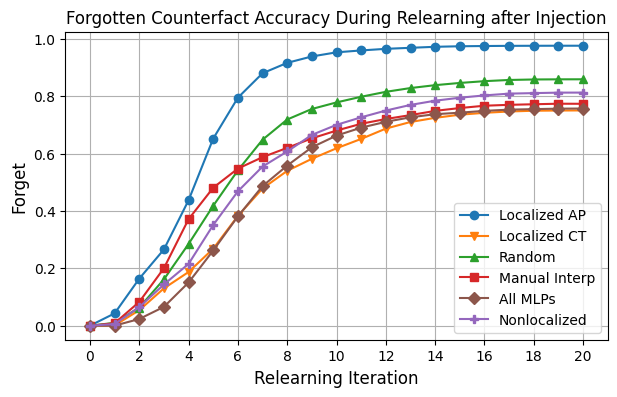

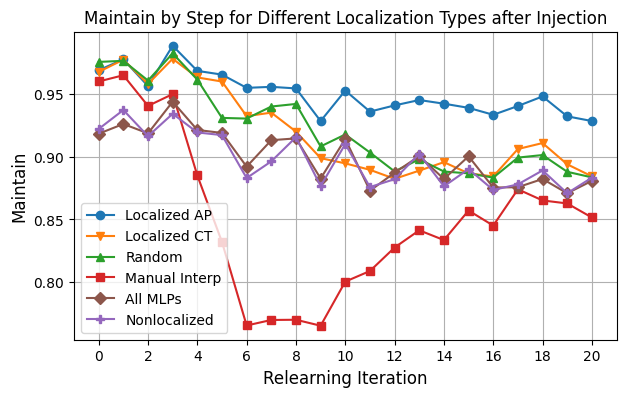

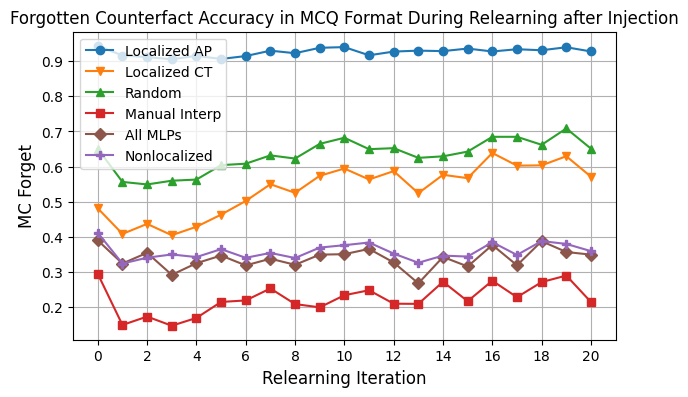

In [15]:
import pandas as pd

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
color_map = {"forget_ap": colors[0], "new_forget_ct": colors[1], "random": colors[2], "manual_interp": colors[3], "nonlocalized": colors[4], "all_mlps": colors[5]}
formal_name_dict = {"forget_ap": "Localized AP", "new_forget_ct": "Localized CT", "random": "Random", "manual_interp": "Manual Interp", "nonlocalized": "Nonlocalized", "all_mlps": "All MLPs"}

type_to_marker = {
    'forget_ap': 'o',
    'new_forget_ct': 'v',
    'random': '^',
    'manual_interp': 's',
    'all_mlps': 'D',
    'nonlocalized': 'P'
}

# Merge the adversarial_evals_df to get the required columns
merged_df = adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain']).reset_index()
merged_df.columns = ['localization_type', 'run_id', 'forget_MC', 'forget_Neighborhood', 'forget_Normal', 'forget_Paraphrase', 'maintain_MC', 'maintain_Neighborhood', 'maintain_Normal', 'maintain_Paraphrase']

# Create new rows with step = -1
new_rows = merged_df.copy()
new_rows['step'] = -1
new_rows['mmlu'] = None  # Leave mmlu blank
new_rows = new_rows.rename(columns={
    'forget_Normal': 'forget',
    'maintain_Normal': 'maintain',
    'forget_MC': 'mc_forget',
    'maintain_MC': 'mc_maintain'
})

# Select and reorder the columns to match relearning_results_df
new_rows = new_rows[['localization_type', 'run_id', 'step', 'mmlu', 'forget', 'maintain', 'mc_forget', 'mc_maintain']]

# Append the new rows to relearning_results_df
combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)

# Display the updated DataFrame
# display(combined_relearning_results_df)

import matplotlib.pyplot as plt

# Group by localization_type and step, then calculate the mean for each metric
mean_metrics = combined_relearning_results_df.groupby(['localization_type', 'step']).mean().reset_index()

localization_order = ["forget_ap", "new_forget_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]

# Function to plot relearning results
def plot_relearning_results(mean_metrics, metric, title, ylabel, formal=True):
    plt.figure(figsize=(7, 4))
    # for localization_type in mean_metrics['localization_type'].unique():
    for localization_type in localization_order:
        subset = mean_metrics[mean_metrics['localization_type'] == localization_type]
        values = subset[metric].tolist()
        if formal:
            plt.plot(subset['step']+1, values, label=formal_name_dict[localization_type], marker=type_to_marker[localization_type], color=color_map[localization_type])
        else:
            plt.plot(subset['step']+1, values, label=localization_type, marker=type_to_marker[localization_type])
    plt.xlabel('Relearning Iteration', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(ticks=range(0, int(mean_metrics['step'].max()) + 2, 2))  # Set x-ticks every 2 steps
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot forget
plot_relearning_results(mean_metrics, 'forget', f'Forgotten Counterfact Accuracy During Relearning{" after Injection" if inject_fact else ""}', 'Forget')

# Plot maintain
plot_relearning_results(mean_metrics, 'maintain', f'Maintain by Step for Different Localization Types{" after Injection" if inject_fact else ""}', 'Maintain')

# Plot mc_forget
plot_relearning_results(mean_metrics, 'mc_forget', f'Forgotten Counterfact Accuracy in MCQ Format During Relearning{" after Injection" if inject_fact else ""}', 'MC Forget')

# Plot mc_maintain
# plot_relearning_results(mean_metrics, 'mc_maintain', 'MC Maintain by Step for Different Localization Types', 'MC Maintain')